# Teil 4: Machine Learning Klassifikation

**Ziel:**
- Decision Tree Classifier auf 3 Features trainieren
- Feature Importance visualisieren
- Modell-Performance evaluieren


### Imports

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for Machine Learning
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from pathlib import Path
import pickle

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10



In [18]:
# Pfade
PROCESSED_DIR = Path('../data/processed')
RESULTS_DIR = Path('../results/figures')
MODELS_DIR = Path('../results/models')
MODELS_DIR.mkdir(exist_ok=True)

# DataFrame laden
df = pd.read_csv(PROCESSED_DIR / 'features_with_labels.csv')

print(f"{len(df)} Bilder")

df.head()

100 Bilder


,file_path,label_is_malignant,stain_quality,patch_size_px,filename,entropy,variance,median,label
0,prepared_patches_p4\texture_patch_0053.png,1,1.0,512,texture_patch_0053.png,4.239908,0.006079,0.338605,Tumor
1,prepared_patches_p4\texture_patch_0087.png,1,2.0,512,texture_patch_0087.png,3.711366,0.002691,0.498107,Tumor
2,prepared_patches_p4\texture_patch_0047.png,0,4.0,512,texture_patch_0047.png,3.722453,0.003374,0.488739,Normal
3,prepared_patches_p4\texture_patch_0080.png,1,NaN,512,texture_patch_0080.png,3.989174,0.006699,0.385998,Tumor
4,prepared_patches_p4\texture_patch_0024.png,0,NaN,512,texture_patch_0024.png,3.764693,0.002072,0.487091,Normal


### Daten vorbereiten


In [19]:
# Features (X) und Labels (y) vorbereiten
feature_columns = ['entropy', 'variance', 'median']
X = df[feature_columns].values
y = df['label_is_malignant'].values  # 0 = Normal, 1 = Tumor

print("Daten vorbereitet:")
print(f"  X shape: {X.shape}  (Anzahl Samples x Anzahl Features)")
print(f"  y shape: {y.shape}  (Anzahl Labels)")
print(X[:5])
print(y[:10])

Daten vorbereitet:
  X shape: (100, 3)  (Anzahl Samples x Anzahl Features)
  y shape: (100,)  (Anzahl Labels)
[[4.23990834e+00 6.07934900e-03 3.38605098e-01]
 [3.71136588e+00 2.69115351e-03 4.98107451e-01]
 [3.72245329e+00 3.37350965e-03 4.88738824e-01]
 [3.98917367e+00 6.69859096e-03 3.85998431e-01]
 [3.76469257e+00 2.07247669e-03 4.87090588e-01]]
[1 1 0 1 0 0 0 1 1 0]


In [20]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,      # 20% für Test
    random_state=42,    # Reproduzierbarkeit
    stratify=y          # Gleiche Label-Verteilung in Train und Test
)

print("Train-Test Split:")
print(f"  Training: {len(X_train)} Samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Test:     {len(X_test)} Samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"\nLabel-Verteilung im Training-Set:")
print(f"  Normal (0): {np.sum(y_train == 0)} Samples")
print(f"  Tumor (1):  {np.sum(y_train == 1)} Samples")

Train-Test Split:
  Training: 80 Samples (80.0%)
  Test:     20 Samples (20.0%)

Label-Verteilung im Training-Set:
  Normal (0): 40 Samples
  Tumor (1):  40 Samples


### Decision Tree Classifier trainieren

In [21]:
# Decision Tree erstellen
clf = DecisionTreeClassifier(
    max_depth=4,           # Maximale Tiefe = 3 Levels
    random_state=42,       # Reproduzierbarkeit
    min_samples_split=4,   # Minimum 4 Samples für Split
    min_samples_leaf=4     # Minimum 2 Samples pro Blatt
)

# Modell trainieren
clf.fit(X_train, y_train)

print("Decision Tree trainiert")
print(f"\nModell-Parameter:")
print(f"  Max Depth: {clf.max_depth}")
print(f"  Actual Depth: {clf.get_depth()}")
print(f"  Number of Leaves: {clf.get_n_leaves()}")

Decision Tree trainiert

Modell-Parameter:
  Max Depth: 4
  Actual Depth: 4
  Number of Leaves: 8


## 4. Modell evaluieren

In [22]:
# Vorhersagen auf Test-Set
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

# Accuracy berechnen
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print("Modell-Performance:")
print(f"  Training Accuracy: {train_accuracy:.3f} ({train_accuracy*100:.1f}%)")
print(f"  Test Accuracy:     {test_accuracy:.3f} ({test_accuracy*100:.1f}%)")

if train_accuracy - test_accuracy > 0.1:
    print("\nHinweis: Große Differenz zwischen Train und Test → mögliches Overfitting")
else:
    print("\nGute Generalisierung - ähnliche Performance auf Train und Test")

Modell-Performance:
  Training Accuracy: 0.800 (80.0%)
  Test Accuracy:     0.750 (75.0%)

Gute Generalisierung - ähnliche Performance auf Train und Test


In [23]:
# Detaillierter Classification Report
print("Classification Report (Test-Set):\n")
print(classification_report(
    y_test, 
    y_pred_test,
    target_names=['Normal', 'Tumor']
))

print("Metriken erklärt:")
print("  Precision: Von allen als Tumor vorhergesagten, wie viele sind wirklich Tumor?")
print("  Recall: Von allen echten Tumoren, wie viele wurden erkannt?")
print("  F1-Score: Harmonisches Mittel von Precision und Recall")

Classification Report (Test-Set):

              precision    recall  f1-score   support

      Normal       0.73      0.80      0.76        10
       Tumor       0.78      0.70      0.74        10

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.75      0.75      0.75        20

Metriken erklärt:
  Precision: Von allen als Tumor vorhergesagten, wie viele sind wirklich Tumor?
  Recall: Von allen echten Tumoren, wie viele wurden erkannt?
  F1-Score: Harmonisches Mittel von Precision und Recall


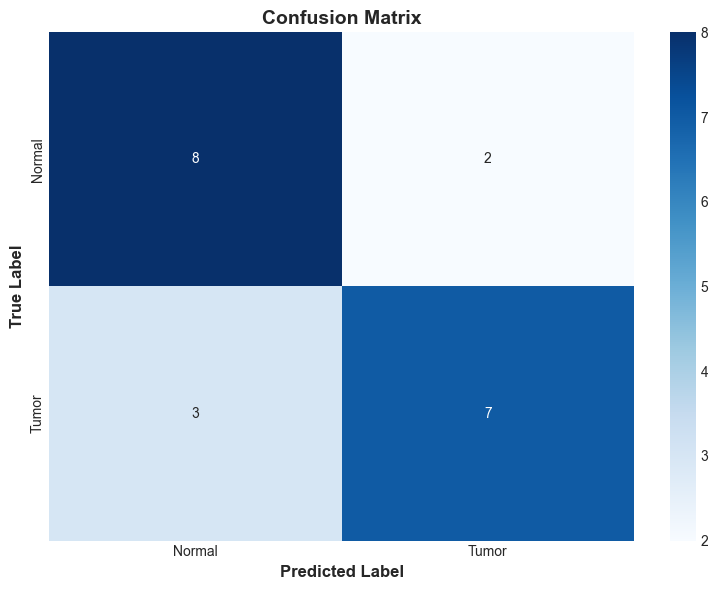

Confusion Matrix erklärt:
  True Negatives (TN):  8 - Korrekt als Normal erkannt
  False Positives (FP): 2 - Fälschlich als Tumor erkannt
  False Negatives (FN): 3 - Fälschlich als Normal erkannt
  True Positives (TP):  7 - Korrekt als Tumor erkannt

Plot gespeichert: results/figures/14_confusion_matrix.png


In [24]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Normal', 'Tumor'],
    yticklabels=['Normal', 'Tumor'],
    ax=ax
)

ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_DIR / '14_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("Confusion Matrix erklärt:")
print(f"  True Negatives (TN):  {cm[0,0]} - Korrekt als Normal erkannt")
print(f"  False Positives (FP): {cm[0,1]} - Fälschlich als Tumor erkannt")
print(f"  False Negatives (FN): {cm[1,0]} - Fälschlich als Normal erkannt")
print(f"  True Positives (TP):  {cm[1,1]} - Korrekt als Tumor erkannt")
print(f"\nPlot gespeichert: results/figures/14_confusion_matrix.png")

## 5. PROJEKTANFORDERUNG: Feature Importance visualisieren

Zeigt, welches Feature am wichtigsten für die Klassifikation ist.

In [25]:
# Feature Importance extrahieren
feature_importance = clf.feature_importances_

print("Feature Importance:")
for i, (feature, importance) in enumerate(zip(feature_columns, feature_importance)):
    print(f"  {feature:10s}: {importance:.4f} ({importance*100:.1f}%)")

# Wichtigstes Feature identifizieren
most_important_idx = np.argmax(feature_importance)
print(f"\nWichtigstes Feature: {feature_columns[most_important_idx]}")
print("Dieses Feature wird für die erste Aufteilung im Baum verwendet")

Feature Importance:
  entropy   : 0.3707 (37.1%)
  variance  : 0.3311 (33.1%)
  median    : 0.2982 (29.8%)

Wichtigstes Feature: entropy
Dieses Feature wird für die erste Aufteilung im Baum verwendet


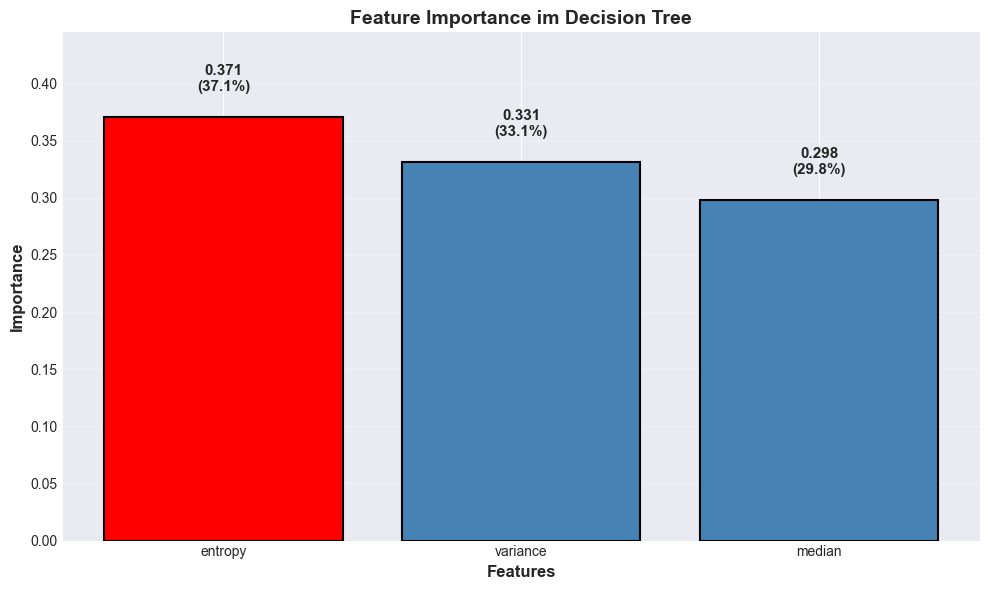

PROJEKTANFORDERUNG erfüllt
Plot gespeichert: results/figures/15_feature_importance.png


In [26]:
# Feature Importance als Barplot
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['red' if i == most_important_idx else 'steelblue' for i in range(len(feature_columns))]

bars = ax.bar(feature_columns, feature_importance, color=colors, edgecolor='black', linewidth=1.5)

# Werte auf Balken anzeigen
for bar, importance in zip(bars, feature_importance):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2.,
        height + 0.02,
        f'{importance:.3f}\n({importance*100:.1f}%)',
        ha='center',
        va='bottom',
        fontsize=11,
        fontweight='bold'
    )

ax.set_xlabel('Features', fontsize=12, fontweight='bold')
ax.set_ylabel('Importance', fontsize=12, fontweight='bold')
ax.set_title('Feature Importance im Decision Tree', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(feature_importance) * 1.2)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(RESULTS_DIR / '15_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("PROJEKTANFORDERUNG erfüllt")
print(f"Plot gespeichert: results/figures/15_feature_importance.png")

## 6. Decision Tree visualisieren

Zeigt die Struktur des Baumes - welche Splits werden gemacht?

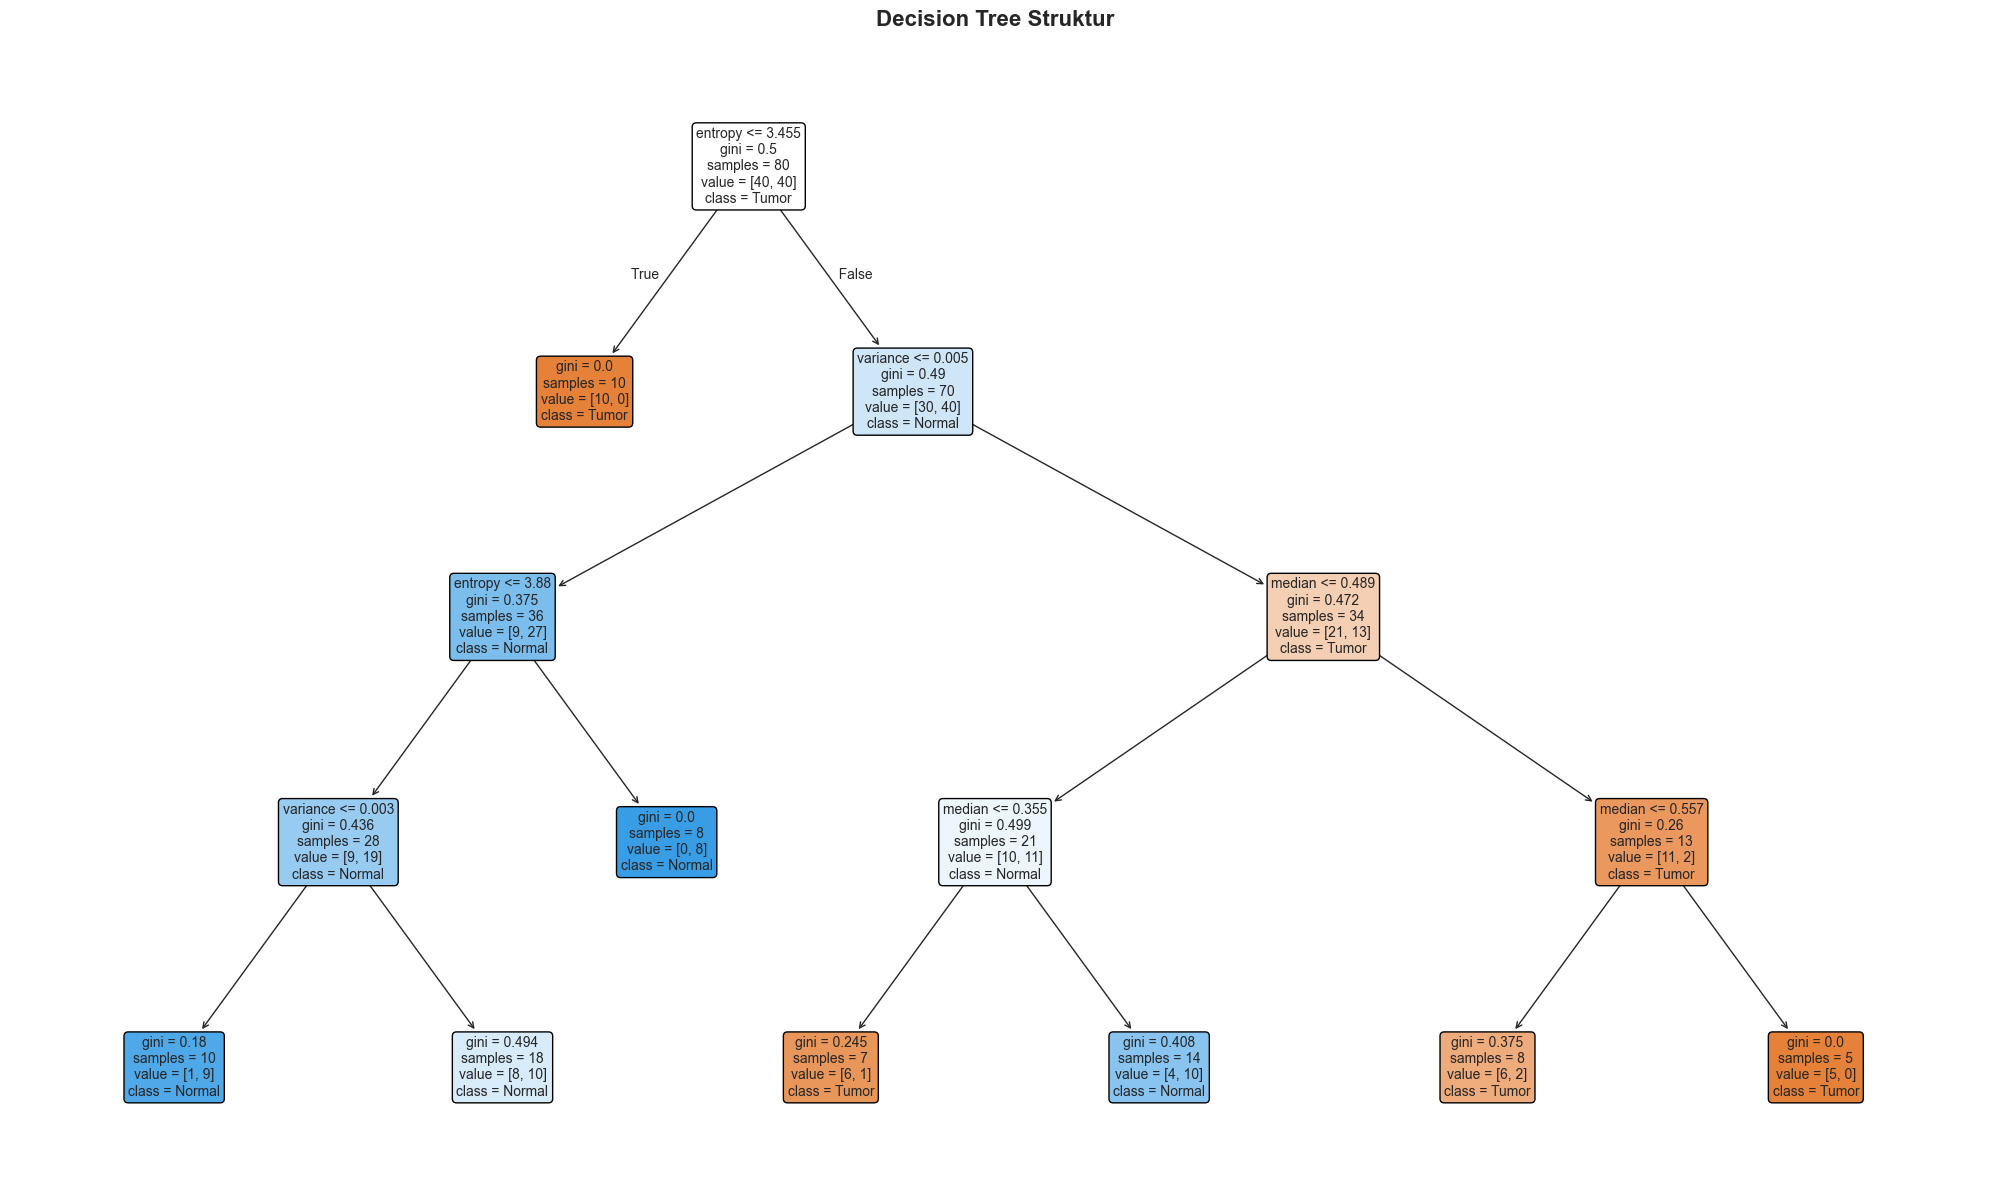

Tree-Visualisierung gespeichert: results/figures/16_decision_tree_structure.png

Wie man den Baum liest:
  - Oberster Knoten (root): Erste Aufteilung
  - Jeder Knoten zeigt: Feature, Threshold, Samples, Klassen-Verteilung
  - Farbe: Orange = mehr Tumor, Blau = mehr Normal
  - Blätter (unten): Finale Vorhersage


In [27]:
# Decision Tree visualisieren
fig, ax = plt.subplots(figsize=(20, 12))

plot_tree(
    clf,
    feature_names=feature_columns,
    class_names=['Tumor', 'Normal'],
    filled=True,
    rounded=True,
    fontsize=10,
    ax=ax
)

ax.set_title('Decision Tree Struktur', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(RESULTS_DIR / '16_decision_tree_structure.png', dpi=150, bbox_inches='tight')
plt.show()

print("Tree-Visualisierung gespeichert: results/figures/16_decision_tree_structure.png")
print("\nWie man den Baum liest:")
print("  - Oberster Knoten (root): Erste Aufteilung")
print("  - Jeder Knoten zeigt: Feature, Threshold, Samples, Klassen-Verteilung")
print("  - Farbe: Orange = mehr Tumor, Blau = mehr Normal")
print("  - Blätter (unten): Finale Vorhersage")

## 7. Modell speichern

In [28]:
# Modell als pickle-Datei speichern
model_path = MODELS_DIR / 'decision_tree_classifier.pkl'

with open(model_path, 'wb') as f:
    pickle.dump(clf, f)

print(f"Modell gespeichert: {model_path}")
print("\nDas Modell kann später geladen werden mit:")
print("  with open('model.pkl', 'rb') as f:")
print("      clf = pickle.load(f)")

Modell gespeichert: ../results/models/decision_tree_classifier.pkl

Das Modell kann später geladen werden mit:
  with open('model.pkl', 'rb') as f:
      clf = pickle.load(f)


## 8. Zusammenfassung Teil 4

### Was wir erreicht haben:

1. Decision Tree Classifier trainiert auf 3 Features
2. Modell-Performance evaluiert:
   - Accuracy, Precision, Recall, F1-Score
   - Confusion Matrix
3. **Feature Importance analysiert** (Projektanforderung erfüllt)
4. Tree-Struktur visualisiert
5. Modell gespeichert

### Erkenntnisse:

**Welches Feature ist am wichtigsten?**
- Siehe Feature Importance Plot
- Dieses Feature wird für die erste Aufteilung verwendet

**Wie gut funktioniert das Modell?**
- Test Accuracy zeigt Generalisierung
- Confusion Matrix zeigt, wo Fehler gemacht werden

**Für die Präsentation:**
- Feature Importance Plot → zeigt wichtigstes Feature
- Tree-Visualisierung → zeigt Entscheidungslogik
- Confusion Matrix → zeigt Performance

---

### ALLE 4 PROJEKTTEILE KOMPLETT

**Teil 1:** Farbraum-Analyse
**Teil 2:** Feature-Extraktion
**Teil 3:** Statistische Analyse & Visualisierung
**Teil 4:** Machine Learning Klassifikation

### Nächste Schritte:

1. Code aufräumen und dokumentieren
2. Alle Plots für Präsentation sammeln
3. README aktualisieren mit Ergebnissen
4. Präsentation vorbereiten

---

**Status:** PROJEKT KOMPLETT

**Bereit für:** Code-Review und Präsentationsvorbereitung

---

In [29]:
from sklearn.model_selection import cross_val_score, cross_validate

print("\n" + "="*60)
print("CROSS-VALIDATION (5-Fold)")
print("="*60 + "\n")

# 5-Fold Cross-Validation mit mehreren Metriken
scoring = ['accuracy', 'precision', 'recall', 'f1']

cv_results = cross_validate(
    clf, 
    X, y, 
    cv=5,
    scoring=scoring,
    return_train_score=True
)

# Ergebnisse ausgeben
print("Test Scores (5 Folds):")
print(f"  Accuracy:  {cv_results['test_accuracy'].mean():.3f} (+/- {cv_results['test_accuracy'].std():.3f})")
print(f"  Precision: {cv_results['test_precision'].mean():.3f} (+/- {cv_results['test_precision'].std():.3f})")
print(f"  Recall:    {cv_results['test_recall'].mean():.3f} (+/- {cv_results['test_recall'].std():.3f})")
print(f"  F1-Score:  {cv_results['test_f1'].mean():.3f} (+/- {cv_results['test_f1'].std():.3f})")

print(f"\nTrain Scores (5 Folds):")
print(f"  Accuracy:  {cv_results['train_accuracy'].mean():.3f} (+/- {cv_results['train_accuracy'].std():.3f})")

print(f"\nInterpretation:")
if cv_results['test_accuracy'].std() < 0.1:
    print("  Geringe Standardabweichung → Stabiles Modell")
else:
    print("  Hohe Standardabweichung → Instabiles Modell")

# Einzelne Fold-Scores anzeigen
print(f"\nAlle 5 Fold Accuracies:")
for i, score in enumerate(cv_results['test_accuracy'], 1):
    print(f"  Fold {i}: {score:.3f}")


CROSS-VALIDATION (5-Fold)

Test Scores (5 Folds):
  Accuracy:  0.650 (+/- 0.055)
  Precision: 0.665 (+/- 0.062)
  Recall:    0.620 (+/- 0.075)
  F1-Score:  0.638 (+/- 0.054)

Train Scores (5 Folds):
  Accuracy:  0.828 (+/- 0.012)

Interpretation:
  Geringe Standardabweichung → Stabiles Modell

Alle 5 Fold Accuracies:
  Fold 1: 0.550
  Fold 2: 0.650
  Fold 3: 0.700
  Fold 4: 0.700
  Fold 5: 0.650



ROC CURVE & AUC

AUC Score: 0.835

Interpretation:
  0.80-0.90: Sehr gut


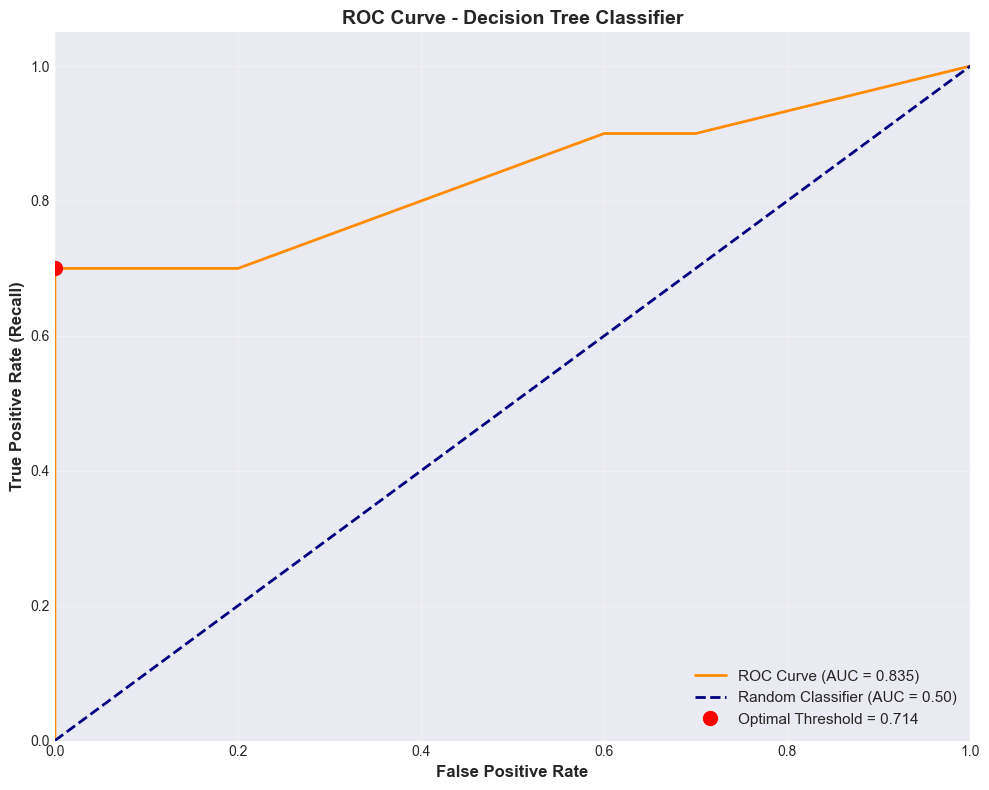


Plot gespeichert: results/figures/17_roc_curve.png

Optimaler Threshold: 0.714
  Bei diesem Threshold:
    False Positive Rate: 0.000
    True Positive Rate:  0.700


In [30]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

print("\n" + "="*60)
print("ROC CURVE & AUC")
print("="*60 + "\n")

# Wahrscheinlichkeiten für positive Klasse (Tumor)
y_proba = clf.predict_proba(X_test)[:, 1]

# ROC Curve berechnen
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

print(f"AUC Score: {roc_auc:.3f}")
print(f"\nInterpretation:")
if roc_auc >= 0.9:
    print("  0.90-1.00: Exzellent")
elif roc_auc >= 0.8:
    print("  0.80-0.90: Sehr gut")
elif roc_auc >= 0.7:
    print("  0.70-0.80: Gut")
elif roc_auc >= 0.6:
    print("  0.60-0.70: Akzeptabel")
else:
    print("  <0.60: Schlecht")

# ROC Curve plotten
fig, ax = plt.subplots(figsize=(10, 8))

# ROC Curve
ax.plot(fpr, tpr, color='darkorange', lw=2, 
        label=f'ROC Curve (AUC = {roc_auc:.3f})')

# Diagonal (Random Classifier)
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
        label='Random Classifier (AUC = 0.50)')

# Optimaler Punkt markieren
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
ax.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=10,
        label=f'Optimal Threshold = {optimal_threshold:.3f}')

# Styling
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate (Recall)', fontsize=12, fontweight='bold')
ax.set_title('ROC Curve - Decision Tree Classifier', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / '17_roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPlot gespeichert: results/figures/17_roc_curve.png")
print(f"\nOptimaler Threshold: {optimal_threshold:.3f}")
print(f"  Bei diesem Threshold:")
print(f"    False Positive Rate: {fpr[optimal_idx]:.3f}")
print(f"    True Positive Rate:  {tpr[optimal_idx]:.3f}")

In [31]:
from sklearn.metrics import recall_score
print("\n" + "="*60)
print("ZUSAMMENFASSUNG: ALLE METRIKEN")
print("="*60 + "\n")

print("Einzelner Train-Test Split (80/20):")
print(f"  Test Accuracy:    {test_accuracy:.3f}")
print(f"  Tumor Recall:     {recall_score(y_test, y_pred_test, pos_label=1):.3f}")
print(f"\n5-Fold Cross-Validation:")
print(f"  Mean Accuracy:    {cv_results['test_accuracy'].mean():.3f} (+/- {cv_results['test_accuracy'].std():.3f})")
print(f"  Mean Recall:      {cv_results['test_recall'].mean():.3f} (+/- {cv_results['test_recall'].std():.3f})")
print(f"\nROC Analysis:")
print(f"  AUC Score:        {roc_auc:.3f}")

print(f"\n" + "="*60)
print("FAZIT:")
print("="*60)

# Entscheidungslogik
if (cv_results['test_accuracy'].mean() > 0.7 and 
    cv_results['test_accuracy'].std() < 0.1 and 
    roc_auc > 0.7):
    print("✓ Stabiles Modell mit guter Performance")
    print("✓ Geringe Varianz zwischen Folds")
    print("✓ AUC zeigt gute Trennfähigkeit")
    print("\n→ Modell ist bereit für Abgabe!")
else:
    print("! Modell zeigt Instabilitäten")
    print("→ Weitere Optimierung empfohlen")


ZUSAMMENFASSUNG: ALLE METRIKEN

Einzelner Train-Test Split (80/20):
  Test Accuracy:    0.750
  Tumor Recall:     0.700

5-Fold Cross-Validation:
  Mean Accuracy:    0.650 (+/- 0.055)
  Mean Recall:      0.620 (+/- 0.075)

ROC Analysis:
  AUC Score:        0.835

FAZIT:
! Modell zeigt Instabilitäten
→ Weitere Optimierung empfohlen


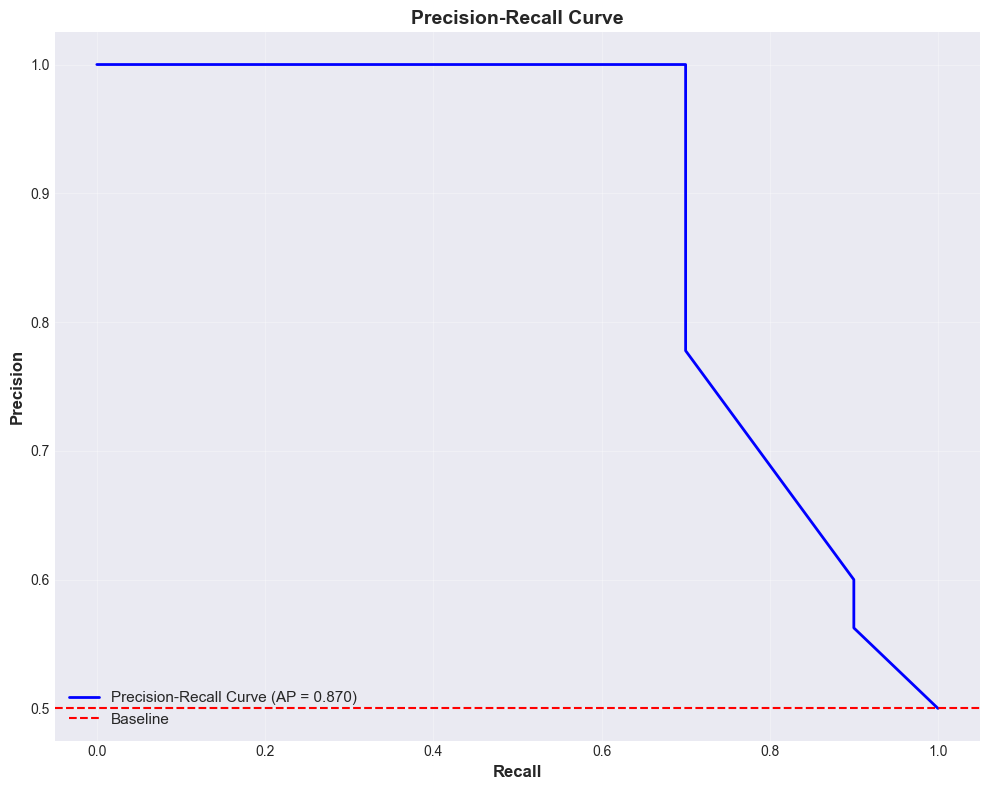

Average Precision Score: 0.870


In [32]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(recall, precision, color='blue', lw=2,
        label=f'Precision-Recall Curve (AP = {avg_precision:.3f})')
ax.axhline(y=0.5, color='red', linestyle='--', label='Baseline')

ax.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
ax.legend(loc="lower left", fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / '18_precision_recall_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Average Precision Score: {avg_precision:.3f}")
